## Multilayer Perceptron (MLP)

### Example 1: Circle Data (Two-Class Classification)  

#### 1. Prepare Data

In this example, We'll use the `make_circles()` method from Scikit-Learn to generate two circles with different coloured dots.

In [189]:
import torch
import numpy as np
from sklearn.datasets import make_circles

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X.shape, y.shape


(torch.Size([1000, 2]), torch.Size([1000]))

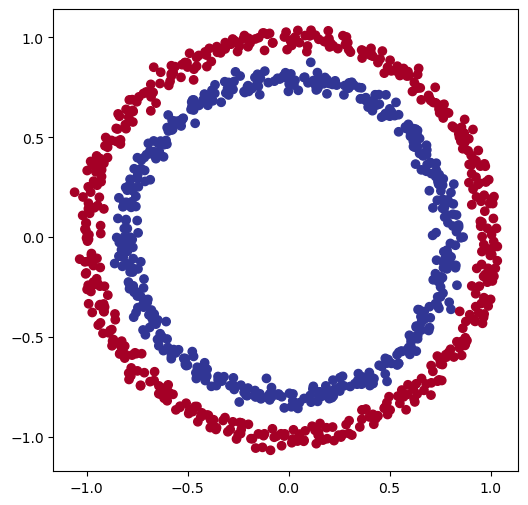

In [190]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu)

In [191]:
# Set device agnostic code
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available
print(f"Used device: {device}\n")

# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Put data on the available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


Used device: mps



#### 2. Build the MLP model

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Parameters for the MLP
input_size = 2 
hidden_size1 = 10
hidden_size2 = 10
output_size = 1  # Example for a 2-class classification

# Define the MLP model for two-class classification
class TwoclassClassificationMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1) 
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.output = nn.Linear(hidden_size2, output_size)
    def forward(self, x):
        x = F.relu(self.hidden1(x))  # Apply ReLU to the output of the first hidden layer
        x = F.relu(self.hidden2(x))  # Apply ReLU to the output of the second hidden layer
        x = self.output(x)           # No activation function here, softmax will be applied later
        return x
    
model_1 = TwoclassClassificationMLP().to(device)

In [193]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)


Note: The `nn.BCEWithLogitsLoss()` loss combines a *Sigmoid* layer and the *BCELoss* in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.

In [194]:
# Define accuracy metric
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

#### 3. Training

In [195]:
# Fit the model
torch.manual_seed(42)
epochs = 2500

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) 
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6925, Accuracy: 50.00% | Test Loss: 0.6944, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.6857, Accuracy: 65.38% | Test Loss: 0.6884, Test Accuracy: 59.50%
Epoch: 200 | Loss: 0.6792, Accuracy: 70.50% | Test Loss: 0.6832, Test Accuracy: 61.00%
Epoch: 300 | Loss: 0.6681, Accuracy: 72.00% | Test Loss: 0.6744, Test Accuracy: 63.00%
Epoch: 400 | Loss: 0.6484, Accuracy: 72.00% | Test Loss: 0.6577, Test Accuracy: 63.50%
Epoch: 500 | Loss: 0.6112, Accuracy: 83.62% | Test Loss: 0.6259, Test Accuracy: 77.50%
Epoch: 600 | Loss: 0.5387, Accuracy: 95.00% | Test Loss: 0.5605, Test Accuracy: 93.00%
Epoch: 700 | Loss: 0.4236, Accuracy: 97.88% | Test Loss: 0.4556, Test Accuracy: 94.00%
Epoch: 800 | Loss: 0.2895, Accuracy: 99.62% | Test Loss: 0.3326, Test Accuracy: 98.00%
Epoch: 900 | Loss: 0.1797, Accuracy: 99.88% | Test Loss: 0.2225, Test Accuracy: 98.50%
Epoch: 1000 | Loss: 0.1147, Accuracy: 99.88% | Test Loss: 0.1541, Test Accuracy: 99.00%
Epoch: 1100 | Loss: 0.0786, Accuracy: 99.88%

#### 4. Evaluation

In [196]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

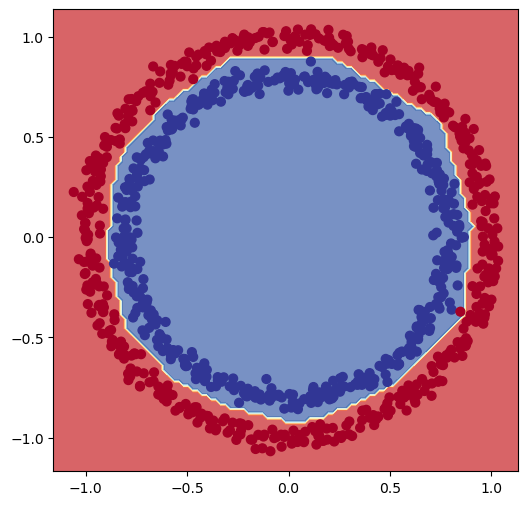

In [197]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(6, 6))
plot_decision_boundary(model_1, X, y)

### Example 2: FashionMNIST Data (10-Class Classification)  

The original *MNIST* dataset contains thousands of examples of handwritten digits (from 0 to 9) and was used to build computer vision models to identify numbers for postal services. *FashionMNIST* is a similar setup. Except it contains grayscale images of 10 different kinds of clothing.

#### 1. Prepare Data

#### 1.1. Load FashionMINST data from `torchvision.datasets`

In [198]:
# Import torchvision 
from torchvision import datasets
from torchvision.transforms import ToTensor

# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
    )

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
    )

In [199]:
# How many samples are there? 
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [200]:
# Shape of the data
train_data.data.shape, train_data.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [201]:
# See targets (response)
train_data.targets[:10]

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])

In [202]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

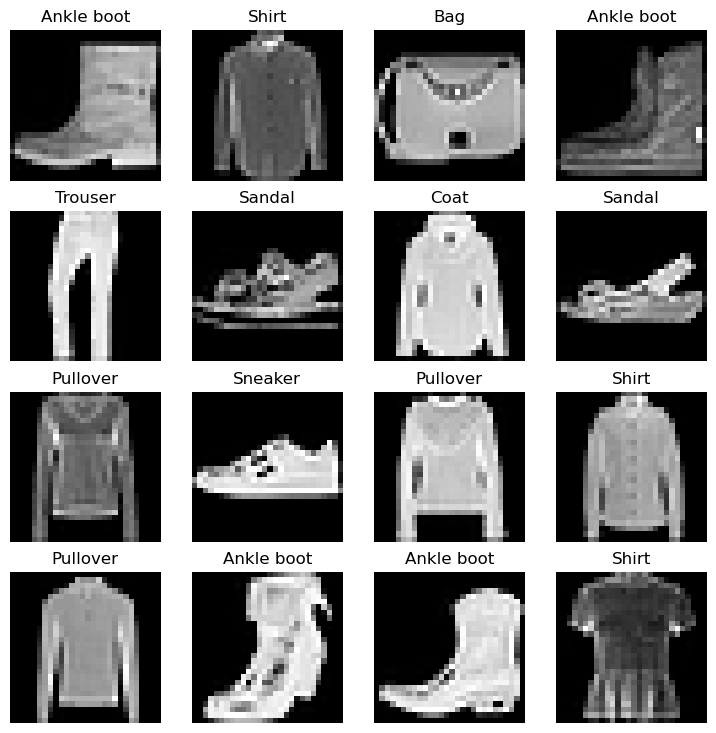

In [203]:
# visualizing data
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(0, rows * cols):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

#### 1.2. Prepare DataLoader

A `DataLoader` is essentially the workhorse that wraps your dataset and handles:

* **Batching**: Automatically groups individual samples into fixed‑size batches.

* **Shuffling**: Randomizes the order of samples each epoch.

* **Parallel loading**: Spawns worker threads/processes (num_workers>0) to load and preprocess data in the background—so your GPU never has to wait on the CPU.

`DataLoader` makes your training loop cleaner, more efficient, and more flexible.

In [204]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 64

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
                              batch_size=BATCH_SIZE, # how many samples per batch? 
                              shuffle=True # shuffle data every epoch?
                              )

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False # don't necessarily have to shuffle the testing data
                             )

# Let's check out what we've created
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 938 batches of 64
Length of test dataloader: 157 batches of 64


In [205]:
# Check out what's inside the training dataloader
# 1. Create an iterator over the dataloader
it = iter(train_dataloader)
# 2. Pull out the next item (i.e. the first batch)
train_features_batch, train_labels_batch = next(it)
# 3. Look at their shapes
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

#### 2. Build the MLP model

In [206]:
import torch
import torch.nn as nn

# Define the MLP model for 10-class classification
class FashionMNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),               
            nn.Linear(28*28, 256), 
            nn.ReLU(),
            nn.Linear(256, 128),  
            nn.ReLU(),
            nn.Linear(128, 64),   
            nn.ReLU(),
            nn.Linear(64, 10)  # Note: don’t add softmax here if you’ll use CrossEntropyLoss
            )
        
    def forward(self, x):
        return self.net(x)
    
model_2 = FashionMNIST_MLP()

Note:
1. The `nn.Flatten()` layer took our shape from `[batch_size, color_channels, height, width]` to `[batch_size, color_channels * height * width]`.
2. The `nn.Sequential()` is a convenient container for "stacking" layers (or any nn.Modules) in the order you list them. 

In [207]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.02)

Note: The criterion `nn.CrossEntropyLoss()` computes the cross entropy loss between input *logits* and target.

#### 3. Training

In [208]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for X, y in train_dataloader:

        model_2.train() 
        # Forward pass
        y_pred = model_2(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_2.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_2(X)
            test_loss += loss_fn(test_pred, y) 
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


    

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------

Train loss: 1.38356 | Test loss: 0.80057, Test acc: 69.03%

Epoch: 1
-------

Train loss: 0.65595 | Test loss: 0.61414, Test acc: 77.81%

Epoch: 2
-------

Train loss: 0.53798 | Test loss: 0.55430, Test acc: 80.47%

Epoch: 3
-------

Train loss: 0.48731 | Test loss: 0.48624, Test acc: 82.90%

Epoch: 4
-------

Train loss: 0.45461 | Test loss: 0.52382, Test acc: 80.74%

Epoch: 5
-------

Train loss: 0.43064 | Test loss: 0.45575, Test acc: 83.88%

Epoch: 6
-------

Train loss: 0.41223 | Test loss: 0.46043, Test acc: 84.05%

Epoch: 7
-------

Train loss: 0.39443 | Test loss: 0.43292, Test acc: 84.61%

Epoch: 8
-------

Train loss: 0.37894 | Test loss: 0.41220, Test acc: 85.42%

Epoch: 9
-------

Train loss: 0.36588 | Test loss: 0.40227, Test acc: 85.47%

Epoch: 10
-------

Train loss: 0.35463 | Test loss: 0.41998, Test acc: 84.93%

Epoch: 11
-------

Train loss: 0.34342 | Test loss: 0.40846, Test acc: 85.26%

Epoch: 12
-------

Train loss: 0.33348 | Test loss: 0.39051, T

#### 4. Save and Evaluate Model 

In [209]:
# Model evaluation

test_acc = 0
model_2.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model_2(X)
        test_loss += loss_fn(test_pred, y) 
        test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
    test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"Test acc: {test_acc:.2f}%\n")

Test acc: 88.99%



In [210]:
# Save model
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "02_FashionMNIST_MLP.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH) 

Saving model to: models/02_FashionMNIST_MLP.pth
